In [1]:
# This notebook includes model developement with target a new target variable as Is_Health_In_Risk

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score

In [3]:
file_path = 'Data/Cleaned_Impact_of_Remote_Work_on_Mental_Health.csv'
df = pd.read_csv(file_path)

#### Encoding

In [4]:
df['Satisfaction_with_Remote_Work_Encoded'] = df['Satisfaction_with_Remote_Work'].apply(lambda x: 1 if x == 'Satisfied' else 0)

In [5]:
df['Sleep_Quality_Encoded'] = df['Sleep_Quality'].apply(lambda x: 2 if x == 'Good' else (1 if x == 'Average' else 0))

In [6]:
def classify_health_risk(row):
    if row['Stress_Level'] == 'High':
        return 1
    elif row['Stress_Level'] == 'Medium' and (row['Mental_Health_Condition'] != 'Unknown' or row['Sleep_Quality_Encoded'] == 0):
        return 1
    elif row['Stress_Level'] == 'Low' and (row['Mental_Health_Condition'] != 'Unknown' or row['Sleep_Quality_Encoded'] == 0):
        return 1
    else:
        return 0

df['Is_Health_In_Risk'] = df.apply(classify_health_risk, axis = 1)

In [7]:
features_to_drop = ['Stress_Level', 'Employee_ID', 'Satisfaction_with_Remote_Work', 'Sleep_Quality', 'Is_Health_In_Risk']

In [8]:
X = pd.get_dummies(df.drop(features_to_drop, axis = 1), drop_first = True)
y = df['Is_Health_In_Risk']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
class_distribution = y_train.value_counts()
print(class_distribution)

Is_Health_In_Risk
1    3584
0     416
Name: count, dtype: int64


## Using Logistic Regression

#### Tuning

In [11]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

clf = GridSearchCV(LogisticRegression(max_iter = 2000), param_grid, scoring = 'f1', cv = 5)
clf.fit(X_train, y_train)
print("Best Parameters:", clf.best_params_)

Best Parameters: {'C': 10, 'solver': 'liblinear'}


#### Train

In [12]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(
    class_weight = 'balanced', 
    C = clf.best_params_['C'], 
    solver = clf.best_params_['solver'], 
    random_state = 42, 
    max_iter = 1000
)

logreg_model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42, solver='liblinear')

#### Predict

In [13]:
y_pred = logreg_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.63      1.00      0.77        98
           1       1.00      0.94      0.97       902

    accuracy                           0.94      1000
   macro avg       0.82      0.97      0.87      1000
weighted avg       0.96      0.94      0.95      1000

Confusion Matrix:
 [[ 98   0]
 [ 57 845]]


#### Change threshold to improve performance

In [14]:
y_probs = logreg_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

y_pred_adjusted = (y_probs >= best_threshold).astype(int)
print("\nClassification Report:\n", classification_report(y_test, y_pred_adjusted))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))


Classification Report:
               precision    recall  f1-score   support

           0       0.64      1.00      0.78        98
           1       1.00      0.94      0.97       902

    accuracy                           0.95      1000
   macro avg       0.82      0.97      0.88      1000
weighted avg       0.97      0.95      0.95      1000

Confusion Matrix:
 [[ 98   0]
 [ 54 848]]


#### Result Visualization

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

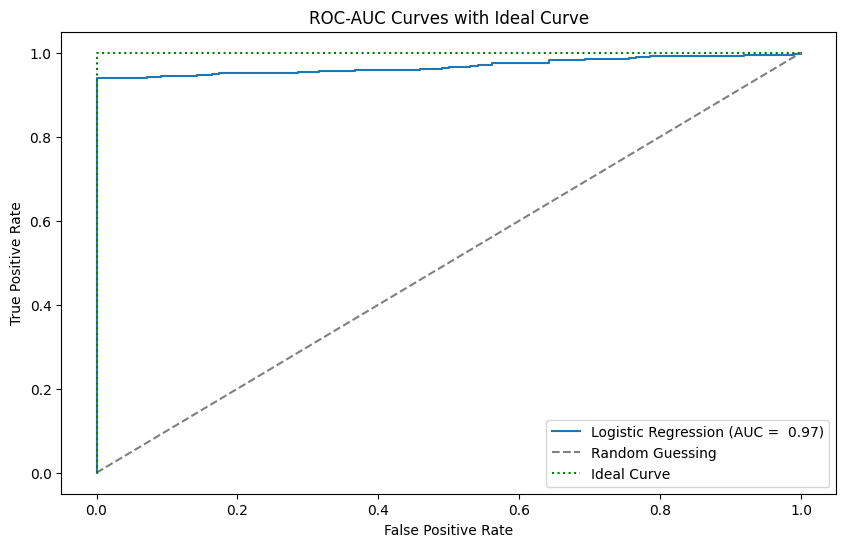

In [16]:
plt.figure(figsize = (10, 6))
plt.plot(fpr, tpr, label = f'Logistic Regression (AUC = {auc : .2f})', linestyle = '-')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guessing')
plt.plot([0, 0, 1], [0, 1, 1], linestyle = ':', color = 'green', label = 'Ideal Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves with Ideal Curve')
plt.legend(loc = 'lower right')
plt.show()